In [1]:
%load_ext autoreload
%autoreload 2

In [84]:
import xarray as xr
import warnings
import os

import cmocean
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
plt.rcParams.update({'font.size': 11})

In [3]:
import gfdl_utils.core as gu

In [4]:
models = {
    "CM4Xp25"  : {"historical":"odiv-231", "ssp5":"odiv-232"},
    "CM4Xp125" : {"historical":"odiv-255", "ssp5":"odiv-293"}
}

In [5]:
tracers = ['cfc11', 'cfc12', 'sf6']
g_per_mol = {
    "cfc11": 137.37,
    "cfc12": 120.91,
    "sf6": 146.06
}
Gg_per_g = 1.e-9
sec_per_year = 365.25 * 24 * 60 * 60
sec_per_nsec = 1.e-9

In [6]:
data_dict = {}

for model in models.keys():
    
    inv_path = f"../data/transient_tracer_inventory_{model}-SSP585.nc"
    if os.path.exists(inv_path):
        print(f"Loading inert tracer inventories for {model}")
        data_dict[model] = xr.open_dataset(inv_path)

Loading inert tracer inventories for CM4Xp25
Loading inert tracer inventories for CM4Xp125


In [7]:
data_dict["CM4Xp125-piControl"] = xr.open_dataset("../data/transient_tracer_inventory_CM4Xp125-piControl.nc")
# align times with historical + SSP5-8.5
data_dict["CM4Xp125-piControl"] = data_dict["CM4Xp125-piControl"].assign_coords(
    {"time": data_dict["CM4Xp125"].time[0:data_dict["CM4Xp125-piControl"].time.size]}
)

In [8]:
import cftime
import numpy as np
import matplotlib.dates as mdates

In [9]:
bc = xr.open_dataset("/archive/hfd/datasets/input_files/CFC_SSP585_20x20deg.20220203.nc", decode_times=False)
bc = bc.assign_coords({'Year': bc['Time'].copy() + 1601})
bc['Year'].attrs = {}
bc['Time'] = bc['Time']*365.242198781
bc['Time'].attrs['units'] = 'days since 1601-01-01 00:00:00'
bc = xr.decode_cf(bc, use_cftime=True)

In [10]:
glo = xr.open_dataset("../data/glodap_v1/glodap_cfc.nc")

R = 6378.1e3
glo['dz'] = xr.ones_like(glo['depth'])
glo['dz'].data = np.diff(glo['depth_bnds'])
glo['dA'] = R**2 * np.abs(np.sin(np.deg2rad(glo['lat']+0.5)) - np.sin(np.deg2rad(glo['lat']-0.5))) * np.deg2rad((glo['lon']+0.5) - (glo['lon']-0.5))
glo['volcello'] = glo.dz * glo.dA

rho0 = 1035.
glo['CFC11_inv'] = (glo.CFC11*1e-12*rho0 * glo.volcello).sum()
glo['CFC12_inv'] = (glo.CFC12*1e-12*rho0 * glo.volcello).sum()

In [80]:
import pandas as pd
wang2021_path = "/work/hfd/datasets/Wang2021_MITgcm_CFCs/data/"
wang2021_CFC11 = pd.read_csv(f"{wang2021_path}MITgcm_rcp_forcing_sensitivity_inventory_CFC11.csv")
wang2021_CFC12 = pd.read_csv(f"{wang2021_path}MITgcm_rcp_forcing_sensitivity_inventory_CFC12.csv")

In [81]:
mass_atm = 5.148e12            # mass of atmosphere, unit in Gg
molar_mass_air = 28.8          # average air molar mass unit in g/mol
molar_mass_CFC11 = 137.37      # CFC11 molar mass, unit in g/mol
molar_mass_CFC12 = 120.91      # CFC11 molar mass, unit in g/mol

ppt_to_Gg11 = (0.95*mass_atm/(molar_mass_air/molar_mass_CFC11) )*1e-12/1.07  # unit transfer from ppt to Gg
Gg_to_ppt11 = 1/ppt_to_Gg11 

ppt_to_Gg12 = (0.95*mass_atm/(molar_mass_air/molar_mass_CFC12) )*1e-12/1.07  # unit transfer from ppt to Gg
Gg_to_ppt12 = 1/ppt_to_Gg12 

In [82]:
import datetime
years = np.array(wang2021_df['Year'], dtype=int)
wang2021_CFC11["Date"] = [cftime.datetime(year=year, month=1, day=1) for year in years]
wang2021_CFC12["Date"] = [cftime.datetime(year=year, month=1, day=1) for year in years]

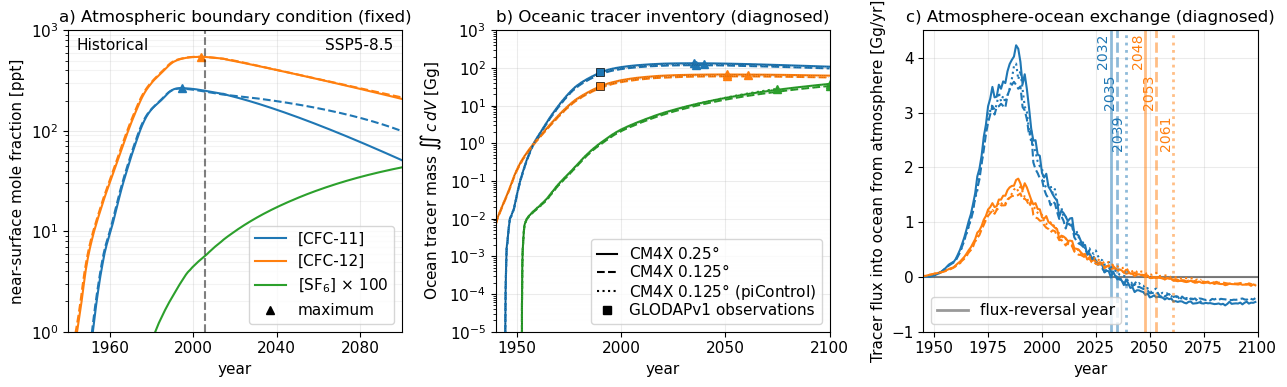

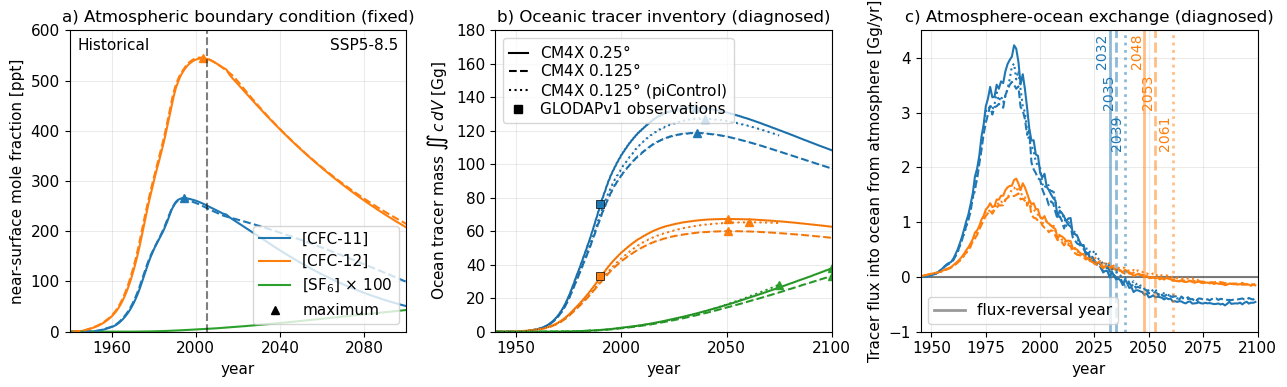

In [85]:
cols = {'cfc11':'C0', 'cfc12':'C1', 'sf6':'C2'}
labels = {'cfc11':'CFC11', 'cfc12':'CFC12', 'sf6':'SF6'}
long_labels = {'cfc11':'[CFC-11]', 'cfc12':'[CFC-12]', 'sf6':r'[SF$_{6}$] $\times$ 100'}
long_exps = {'historical': 'Historical', 'ssp585':'SSP5-8.5'}

for yscale, ylim1, ylim2 in zip(
        ["log", "linear"],
        [[1., 1e3], [0., 600]],
        [[1e-5, 1e3], [0., 180]]
    ):
    fig = plt.figure(figsize=(13, 4))

    ax = plt.subplot(1,3,1)

    for ((_, long_label), (tr, label)) in zip(long_labels.items(), labels.items()):
        scale = 100 if tr == "sf6" else 1
        line = bc[label].mean(['Longitude', 'Latitude']).plot(label=long_label, color=cols[tr])
        timax = bc[label].mean(['Longitude', 'Latitude']).argmax()
        plt.plot(
            bc[label].mean(['Longitude', 'Latitude']).isel(Time=[timax])['Time'],
            bc[label].mean(['Longitude', 'Latitude']).isel(Time=[timax]) * scale,
            '^', linewidth=0., color=line[0].get_c()
        )
    
    plt.plot(wang2021_CFC11['Date'], wang2021_CFC11['hist_atm']*Gg_to_ppt11, linestyle="--")
    plt.plot(wang2021_CFC12['Date'], wang2021_CFC12['hist_atm']*Gg_to_ppt12, linestyle="--")
    plt.plot([], [], "k^", label="maximum")
    plt.axvline(2014, linestyle="--", color="k", alpha=0.5, linewidth=1.5)
    plt.xlim([cftime.datetime(1940, 1, 1), cftime.datetime(2100, 1, 1)])
    plt.grid(True, alpha=0.25, which="major", lw=0.75)
    plt.grid(True, alpha=0.15, which="minor")
    plt.ylabel("near-surface mole fraction [ppt]")
    plt.annotate(long_exps['historical'], xy=(0.025, 0.975), xycoords="axes fraction", ha="left", va="top")
    plt.annotate(long_exps['ssp585'], xy=(0.975, 0.975), xycoords="axes fraction", ha="right", va="top")
    plt.legend(loc="lower right")
    plt.ylim(ylim1)
    plt.yscale(yscale)
    plt.xlabel("year")
    plt.title("a) Atmospheric boundary condition (fixed)", fontsize=12)

    ax = plt.subplot(1,3,2)
    for (model, inv), ls in zip(data_dict.items(), ["-", "--", ":"]):
        for tr in tracers:
            scale = 100 if tr == "sf6" else 1
            line = plt.plot(
                inv['time'],
                inv[f'{tr}_volumeint'] * g_per_mol[tr] * Gg_per_g * scale,
                color=cols[tr], ls=ls
            )
            timax = inv[f'{tr}_volumeint'].argmax()
            plt.plot(
                inv[f'{tr}_volumeint'].isel(time=[timax])['time'],
                inv[f'{tr}_volumeint'].isel(time=[timax]) * g_per_mol[tr] * Gg_per_g * scale,
                '^', linewidth=0., color=line[0].get_c()
            )
            (inv[f'fg{tr}_areatimeint'] * g_per_mol[tr] * Gg_per_g * scale).plot(
                color="k", ls=":", alpha=0.3, lw=0.5
            )

    for tr, color in zip(['cfc11', 'cfc12'], ["C0", "C1"]):
        scale = 100 if tr == "sf6" else 1
        plt.plot(
            cftime.datetime(1990, 1, 1),
            glo[f'{labels[tr]}_inv'] * g_per_mol[tr] * Gg_per_g * scale,
            marker="s", color=color, markeredgecolor="k", markeredgewidth=0.5
        )
    plt.xlim([cftime.datetime(1940, 1, 1), cftime.datetime(2100, 1, 1)])
    plt.grid(True, alpha=0.25, which="major", lw=0.75)
    plt.grid(True, alpha=0.15, which="minor", lw=0.05)
    plt.ylabel(r"Ocean tracer mass $ \iint\, c \, dV$ [Gg]")
    plt.plot([], [], ls="-", color="k", label=r"CM4X 0.25$\degree$")
    plt.plot([], [], ls="--", color="k", label=r"CM4X 0.125$\degree$")
    plt.plot([], [], ls=":", color="k", label=r"CM4X 0.125$\degree$ (piControl)")
    #plt.plot([], [], ls="-.", color="k", alpha=0.4, lw=0.5, label=r"$\int \left( \iint\,F_{c} \, dA \right) \, dt$")
    plt.plot([], [], "ks", label=r"GLODAPv1 observations")
    plt.legend(labelspacing=0.085, handlelength=1.25)
    plt.xlabel("year")
    plt.ylim(ylim2)
    plt.yscale(yscale)
    plt.title("b) Oceanic tracer inventory (diagnosed)", fontsize=12)
    
    plt.subplot(1,3,3)
    plt.axhline(0., color="k", lw=1.5, alpha=0.5)
    for pidx, ((model, inv), ls) in enumerate(zip(data_dict.items(), ["-", "--", ":"])):
        for tr in tracers:
            if "sf6" in tr: continue
            tr_flux = inv[f'fg{tr}_areaint'].groupby("time.year").mean("time") * g_per_mol[tr] * sec_per_year * Gg_per_g
            line = tr_flux.plot(ls=ls, color=cols[tr])
            reversal_year = tr_flux['year'].isel(year=np.abs(tr_flux).where(tr_flux['year'] > 2000).argmin())
            plt.axvline(reversal_year, color=line[0].get_color(), ls=ls, alpha=0.5, lw=2)
            plt.annotate(str(reversal_year.values), (reversal_year-0.25, 4.45 -0.75*pidx), rotation="vertical", ha="right", va="top", color=line[0].get_color(), fontsize=10)

    plt.plot([], [], color="k", alpha=0.4, lw=2, label="flux-reversal year")
    plt.legend()
    plt.xlim([1945, 2100])
    plt.ylim(-1, 4.5)
    plt.grid(True, alpha=0.25, which="major", lw=0.75)
    plt.grid(True, alpha=0.15, which="minor", lw=0.05)
    plt.ylabel("Tracer flux into ocean from atmosphere [Gg/yr]")
    plt.title("c) Atmosphere-ocean exchange (diagnosed)", fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"../figures/transient_tracer_boundary_conditions_and_inventories_{yscale}.png", dpi=300., bbox_inches="tight")

In [49]:
import doralite
sg = xr.open_dataset("/archive/Raphael.Dussin/datasets/OM4p125/mosaic_c192_om4p125_bedmachine_v20210310_hydrographyKDunne20210614_unpacked/ocean_hgrid.nc")
og = gu.open_static(doralite.dora_metadata("odiv-255")["pathPP"], "ocean_annual")

In [50]:
og = og.assign_coords({
    'geolon'  : xr.DataArray(sg['x'][1::2,1::2].data, dims=["yh", "xh"]),
    'geolat'  : xr.DataArray(sg['y'][1::2,1::2].data, dims=["yh", "xh"]),
    'geolon_u': xr.DataArray(sg['x'][1::2,0::2].data, dims=["yh", "xq"]),
    'geolat_u': xr.DataArray(sg['y'][1::2,0::2].data, dims=["yh", "xq"]),
    'geolon_v': xr.DataArray(sg['x'][0::2,1::2].data, dims=["yq", "xh"]),
    'geolat_v': xr.DataArray(sg['y'][0::2,1::2].data, dims=["yq", "xh"]),
    'geolon_c': xr.DataArray(sg['x'][0::2,0::2].data, dims=["yq", "xq"]),
    'geolat_c': xr.DataArray(sg['y'][0::2,0::2].data, dims=["yq", "xq"])
})

/vftmp/Henri.Drake/pid5324/ipykernel_31855/2798474133.py:54: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(


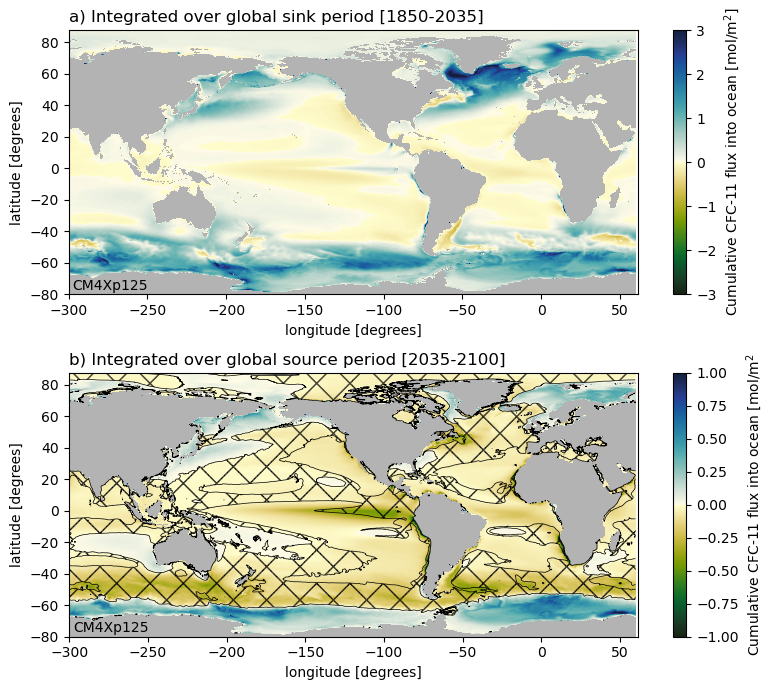

In [125]:
import cmocean
cmap = cmocean.cm.delta_r.copy()
cmap.set_bad((0.7, 0.7, 0.7))

fig, axes = plt.subplots(2,1,figsize=(8,7))
inv = data_dict["CM4Xp125"]

## Sink
plt.sca(axes[0])
fgcfc11_sink_plot = inv['fgcfc11_sink'].where(og.deptho.values > 0)
plt.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    fgcfc11_sink_plot*1e5,
    vmin=-3,
    vmax=3,
    cmap=cmap
)
plt.colorbar(label=r"Cumulative CFC-11 flux into ocean [mol/m$^{2}$]")
plt.xlabel("longitude [degrees]")
plt.ylabel("latitude [degrees]")
plt.title("a) Integrated over global sink period [1850-2035]", loc="left")
plt.annotate(
    "CM4Xp125", (-297.5, -79), rotation="horizontal",
    ha="left", va="bottom", color="k", fontsize=10
)
plt.ylim(-80, 87.5)

## Source
plt.sca(axes[1])
fgcfc11_source_plot = inv['fgcfc11_source'].where(og.deptho.values > 0)
plt.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    fgcfc11_source_plot*1e5,
    vmin=-1,
    vmax=1,
    cmap=cmap
)
plt.colorbar(label=r"Cumulative CFC-11 flux into ocean [mol/m$^{2}$")

sink_to_source = (inv['fgcfc11_sink'] > 0) & (inv['fgcfc11_source'] < 0)
plt.contour(
    og.geolon,
    og.geolat,
    sink_to_source,
    levels=[0.5], linestyles="solid", colors="k", linewidths=0.5
)
fgcfc11_source_plot_masked = np.ma.masked_array(
    fgcfc11_source_plot,
    mask=np.logical_not(sink_to_source)
)
N = 8
plt.pcolor(
    og.geolon[N//2::N,N//2::N],
    og.geolat[N//2::N,N//2::N],
    fgcfc11_source_plot_masked[N//2::N,N//2::N],
    hatch='X',
    alpha=0.
)

plt.xlabel("longitude [degrees]")
plt.ylabel("latitude [degrees]")
plt.title("b) Integrated over global source period [2035-2100]", loc="left")
plt.ylim(-80, 87.5)
plt.annotate(
    "CM4Xp125", (-297.5, -79), rotation="horizontal",
    ha="left", va="bottom", color="k", fontsize=10
)
plt.tight_layout()

plt.savefig("../figures/integrated_flux_cfc11.png", dpi=400, bbox_inches="tight")

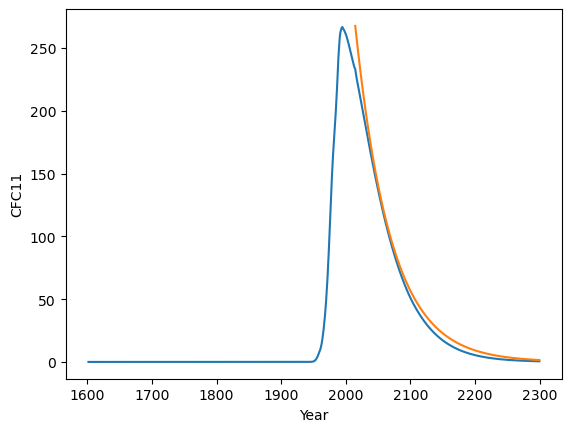

In [219]:
bc["CFC11"].mean(['Longitude', 'Latitude']).plot(x="Year")
x = bc.Year
τ = 55.
y = 270 * np.exp(- (bc.Year - 2014)/τ).where(bc.Year >= 2014)
plt.plot(x, y)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

t = -5
ρ0 = 1035. # kg/m^3

cmap = plt.get_cmap("plasma").copy()
cmap.set_bad((0.25, 0.25, 0.25))
fig, axes = plt.subplots(3,1, figsize=(12, 10))
for i, tr in enumerate(['cfc11', 'cfc12', 'sf6'], start=0):
    pc = (ds_z[tr]/ρ0*1e12).roll(xh=485).sel(yh=-32.5, method="nearest").isel(time=t).plot(
        ax=axes[i],
        cmap=cmap, levels=21,
        vmin=0, vmax=0.2,
    )
    pc.colorbar.set_label("Concentration [pmol/kg]")
    axes[i].set_ylim(6000, 3000)
    axes[i].set_title(f"{ds[tr].long_name} at time {ds.time.isel(time=t).values}")
fig.tight_layout()